In [1]:
NOTEBOOK_NAME = "e003_use_group_k_fold"

In [2]:
import os
import pickle
import numpy as np
import pandas as pd
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold, StratifiedGroupKFold
from sklearn.metrics import roc_auc_score
import seaborn as sns
import japanize_matplotlib
from tqdm.auto import tqdm
from sklearn.metrics import mean_squared_error

In [3]:
class Config:
    OUTPUT_DIR = f"../saved_data/{NOTEBOOK_NAME}"
    SEED = 33
    TARGET_COL = "reserve"


os.makedirs(Config.OUTPUT_DIR, exist_ok=True)

In [4]:
# train_log = pd.read_csv("../data/train_log.csv")
train_label = pd.read_csv("../data/train_label.csv")

test_log = pd.read_csv("../data/test_log.csv")
test_session = pd.read_csv("../data/test_session.csv")

yado = pd.read_csv("../data/yado.csv")

sample_submission = pd.read_csv("../data/sample_submission.csv")

# # image_embeddings = pd.read_parquet("../data/image_embeddings.parquet")

In [5]:
train = pd.read_pickle(
    f"../saved_data/e002_make_train/e002_make_train_merged_train.pkl"
)

test = pd.read_pickle(
    f"../saved_data/e001_make_test/e001_make_test_test_same_lrg_cd_wo_last_yad_no.pkl"
)

In [6]:
# # debug
# train = train.sample(10000, random_state=Config.SEED).reset_index(drop=True)
# test = test.sample(10000, random_state=Config.SEED).reset_index(drop=True)

In [7]:
# debug用
# train = train.sample(10000, random_state=SEED)

In [8]:
# ひとつ前のlogのyad_idの値を取得
train["previous_1_yad_no"] = train["logged_yad_no_list"].apply(lambda x: x[-1])
test["previous_1_yad_no"] = test["logged_yad_no_list"].apply(lambda x: x[-1])

In [9]:
train["session_id"].unique()

array(['000007603d533d30453cc45d0f3d119f',
       '0000ca043ed437a1472c9d1d154eb49b',
       '0000d4835cf113316fe447e2f80ba1c8', ...,
       'ffff7fb4617164b2604aaf51c40bf82d',
       'ffffcd5bc19d62cad5a3815c87818d83',
       'fffffa7baf370083ebcdd98f26a7e31a'], dtype=object)

# 正解のyadoと1つ前のyadoの情報の追加

In [67]:
train

,session_id,yad_no,reserve,logged_yad_no_list,previous_1_yad_no,now_yad_no,now_yad_type,now_total_room_cnt,now_wireless_lan_flg,now_onsen_flg,...,previous_1_onsen_flg,previous_1_kd_stn_5min,previous_1_kd_bch_5min,previous_1_kd_slp_5min,previous_1_kd_conv_walk_5min,previous_1_wid_cd,previous_1_ken_cd,previous_1_lrg_cd,previous_1_sml_cd,fold
0,000007603d533d30453cc45d0f3d119f,4101,1,[2395],2395,4101,0,39.0,NaN,0,...,0,NaN,NaN,NaN,NaN,dc414a17890cfc17d011d5038b88ca93,d78f53d0856617bc782f02c3280dfef2,4fd631b15116098340cdb099c86a5a40,4044dac1931ddaa5a967e09506d76343,0
1,0000ca043ed437a1472c9d1d154eb49b,8253,1,[13535],13535,8253,0,26.0,1.0,0,...,0,1.0,NaN,NaN,1.0,b07b75d367ebece55a23ceecc939fff4,0a66f6ab9c0507059da6f22a0e1f1690,9ab5718fd88c6e5f9fec37a51827d428,7aff71bb47acb796d425c5ed5e6dfb3f,1
2,0000d4835cf113316fe447e2f80ba1c8,4863,1,[123],123,4863,0,30.0,1.0,0,...,0,NaN,NaN,NaN,NaN,46e33861f921c3e38b81998fbf283f01,572d60f0f5212aacda515ebf81fb0a3a,dac434451fe9bd50068191f41fe792e3,b7c56c5d2855b39366b4ebe9a4eded93,2
3,0000fcda1ae1b2f431e55a7075d1f500,1652,1,[8475],8475,1652,0,127.0,1.0,0,...,0,1.0,NaN,NaN,1.0,46e33861f921c3e38b81998fbf283f01,107c7305a74c8dcc4f143de208bf7ec2,3a6cd37aa9e38fd96d9dafc2615643d0,f2fcbd8e62872147efde0acef474e1f2,3
4,000104bdffaaad1a1e0a9ebacf585f33,96,1,"[96, 898]",898,96,0,228.0,1.0,0,...,0,NaN,NaN,NaN,1.0,e9316013ee1b03f4525fe361c46ce9c5,84efa50e52f9b471c95bfc3b21b854ad,a1370d90ed3b80ee41311bbbab46aec9,d72674f02c5340d90f245e3177727650,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1732078,fffffa7baf370083ebcdd98f26a7e31a,1028,0,"[2439, 11822]",11822,1028,0,11.0,1.0,0,...,0,1.0,NaN,NaN,1.0,46e33861f921c3e38b81998fbf283f01,572d60f0f5212aacda515ebf81fb0a3a,8a623b960557e87bd1f4edf71b6255be,ab9480fd72a44d51690ab16c4ad4d49c,3
1732079,fffffa7baf370083ebcdd98f26a7e31a,5607,0,"[2439, 11822]",11822,5607,0,706.0,1.0,0,...,0,1.0,NaN,NaN,1.0,46e33861f921c3e38b81998fbf283f01,572d60f0f5212aacda515ebf81fb0a3a,8a623b960557e87bd1f4edf71b6255be,ab9480fd72a44d51690ab16c4ad4d49c,3
1732080,fffffa7baf370083ebcdd98f26a7e31a,532,0,"[2439, 11822]",11822,532,0,427.0,1.0,0,...,0,1.0,NaN,NaN,1.0,46e33861f921c3e38b81998fbf283f01,572d60f0f5212aacda515ebf81fb0a3a,8a623b960557e87bd1f4edf71b6255be,ab9480fd72a44d51690ab16c4ad4d49c,3
1732081,fffffa7baf370083ebcdd98f26a7e31a,11919,0,"[2439, 11822]",11822,11919,0,71.0,1.0,0,...,0,1.0,NaN,NaN,1.0,46e33861f921c3e38b81998fbf283f01,572d60f0f5212aacda515ebf81fb0a3a,8a623b960557e87bd1f4edf71b6255be,ab9480fd72a44d51690ab16c4ad4d49c,3


In [10]:
# 正解のyado情報の追加
train = pd.merge(
    train,
    yado.add_prefix("now_"),
    left_on="yad_no",
    right_on="now_yad_no",
    how="left",
)

# 1つ前のyado情報の追加
train = pd.merge(
    train,
    yado.add_prefix("previous_1_"),
    on="previous_1_yad_no",
    how="left",
)

In [11]:
# 正解のyado情報の追加
test = pd.merge(
    test,
    yado.add_prefix("now_"),
    left_on="yad_no",
    right_on="now_yad_no",
    how="left",
)

# 1つ前のyado情報の追加
test = pd.merge(
    test,
    yado.add_prefix("previous_1_"),
    on="previous_1_yad_no",
    how="left",
)

In [12]:
train.head()

,session_id,yad_no,reserve,logged_yad_no_list,previous_1_yad_no,now_yad_no,now_yad_type,now_total_room_cnt,now_wireless_lan_flg,now_onsen_flg,...,previous_1_wireless_lan_flg,previous_1_onsen_flg,previous_1_kd_stn_5min,previous_1_kd_bch_5min,previous_1_kd_slp_5min,previous_1_kd_conv_walk_5min,previous_1_wid_cd,previous_1_ken_cd,previous_1_lrg_cd,previous_1_sml_cd
0,000007603d533d30453cc45d0f3d119f,4101,1,[2395],2395,4101,0,39.0,NaN,0,...,1.0,0,NaN,NaN,NaN,NaN,dc414a17890cfc17d011d5038b88ca93,d78f53d0856617bc782f02c3280dfef2,4fd631b15116098340cdb099c86a5a40,4044dac1931ddaa5a967e09506d76343
1,0000ca043ed437a1472c9d1d154eb49b,8253,1,[13535],13535,8253,0,26.0,1.0,0,...,1.0,0,1.0,NaN,NaN,1.0,b07b75d367ebece55a23ceecc939fff4,0a66f6ab9c0507059da6f22a0e1f1690,9ab5718fd88c6e5f9fec37a51827d428,7aff71bb47acb796d425c5ed5e6dfb3f
2,0000d4835cf113316fe447e2f80ba1c8,4863,1,[123],123,4863,0,30.0,1.0,0,...,1.0,0,NaN,NaN,NaN,NaN,46e33861f921c3e38b81998fbf283f01,572d60f0f5212aacda515ebf81fb0a3a,dac434451fe9bd50068191f41fe792e3,b7c56c5d2855b39366b4ebe9a4eded93
3,0000fcda1ae1b2f431e55a7075d1f500,1652,1,[8475],8475,1652,0,127.0,1.0,0,...,1.0,0,1.0,NaN,NaN,1.0,46e33861f921c3e38b81998fbf283f01,107c7305a74c8dcc4f143de208bf7ec2,3a6cd37aa9e38fd96d9dafc2615643d0,f2fcbd8e62872147efde0acef474e1f2
4,000104bdffaaad1a1e0a9ebacf585f33,96,1,"[96, 898]",898,96,0,228.0,1.0,0,...,1.0,0,NaN,NaN,NaN,1.0,e9316013ee1b03f4525fe361c46ce9c5,84efa50e52f9b471c95bfc3b21b854ad,a1370d90ed3b80ee41311bbbab46aec9,d72674f02c5340d90f245e3177727650


In [13]:
test.head()

,session_id,yad_no,logged_yad_no_list,last_yad_no,previous_1_yad_no,now_yad_no,now_yad_type,now_total_room_cnt,now_wireless_lan_flg,now_onsen_flg,...,previous_1_wireless_lan_flg,previous_1_onsen_flg,previous_1_kd_stn_5min,previous_1_kd_bch_5min,previous_1_kd_slp_5min,previous_1_kd_conv_walk_5min,previous_1_wid_cd,previous_1_ken_cd,previous_1_lrg_cd,previous_1_sml_cd
0,00001149e9c73985425197104712478c,337,"[3560, 1959]",1959,1959,337,0,6.0,NaN,0,...,1.0,0,1.0,NaN,NaN,1.0,46e33861f921c3e38b81998fbf283f01,107c7305a74c8dcc4f143de208bf7ec2,52ca3d2824fc3cc90bd4274423badeed,87d9490219b3778f73c41b8176cf30d0
1,00001149e9c73985425197104712478c,360,"[3560, 1959]",1959,1959,360,0,134.0,1.0,0,...,1.0,0,1.0,NaN,NaN,1.0,46e33861f921c3e38b81998fbf283f01,107c7305a74c8dcc4f143de208bf7ec2,52ca3d2824fc3cc90bd4274423badeed,87d9490219b3778f73c41b8176cf30d0
2,00001149e9c73985425197104712478c,930,"[3560, 1959]",1959,1959,930,0,408.0,1.0,0,...,1.0,0,1.0,NaN,NaN,1.0,46e33861f921c3e38b81998fbf283f01,107c7305a74c8dcc4f143de208bf7ec2,52ca3d2824fc3cc90bd4274423badeed,87d9490219b3778f73c41b8176cf30d0
3,00001149e9c73985425197104712478c,1063,"[3560, 1959]",1959,1959,1063,0,60.0,1.0,0,...,1.0,0,1.0,NaN,NaN,1.0,46e33861f921c3e38b81998fbf283f01,107c7305a74c8dcc4f143de208bf7ec2,52ca3d2824fc3cc90bd4274423badeed,87d9490219b3778f73c41b8176cf30d0
4,00001149e9c73985425197104712478c,1286,"[3560, 1959]",1959,1959,1286,0,NaN,NaN,0,...,1.0,0,1.0,NaN,NaN,1.0,46e33861f921c3e38b81998fbf283f01,107c7305a74c8dcc4f143de208bf7ec2,52ca3d2824fc3cc90bd4274423badeed,87d9490219b3778f73c41b8176cf30d0


# データ型の変更

In [14]:
# categorical_colの定義
base_categorical_cols = [
    "yad_no",
    "yad_type",
    # "wid_cd", # retrieveの条件が同じlrg_cdのデータの予定のため、今は学習に使わない
    # "ken_cd", # retrieveの条件が同じlrg_cdのデータの予定のため、今は学習に使わない
    # "lrg_cd", # retrieveの条件が同じlrg_cdのデータの予定のため、今は学習に使わない
    "sml_cd",
]
now_yado_categorical_cols = [f"now_{col}" for col in base_categorical_cols]
previous_1_yado_categorical_cols = [
    f"previous_1_{col}" for col in base_categorical_cols
]

categorical_cols = now_yado_categorical_cols + previous_1_yado_categorical_cols

In [15]:
for col in categorical_cols:
    train[col] = train[col].astype("category")
    test[col] = test[col].astype("category")

# Fold

In [16]:
# Cross Validationの際に用いるfold(分割する際のグループ番号)を追加
FOLD_NUM = 5

# skf = StratifiedKFold(n_splits=FOLD_NUM, shuffle=True, random_state=42)
# for fold, (_, v_idx) in enumerate(
#     skf.split(train, pd.cut(train["reserve"], bins=3, labels=["0", "0.5", "1"]))
# ):
#     train.loc[v_idx, "fold"] = fold

sgkf = StratifiedGroupKFold(n_splits=FOLD_NUM, shuffle=True, random_state=Config.SEED)
for fold, (_, v_idx) in enumerate(
    sgkf.split(
        X=train,
        y=train["reserve"],
        groups=train["session_id"],
    )
):
    train.loc[v_idx, "fold"] = fold

train["fold"] = train["fold"].astype(int)

In [17]:
train.groupby("fold")["reserve"].value_counts(normalize=True)

fold  reserve
0     0          0.833324
      1          0.166676
1     0          0.833325
      1          0.166675
2     0          0.833321
      1          0.166679
3     0          0.833321
      1          0.166679
4     0          0.833325
      1          0.166675
Name: proportion, dtype: float64

# LightGBM

In [18]:
# numeric_colの定義
base_numeric_col = [
    "total_room_cnt",
    "wireless_lan_flg",
    "onsen_flg",
    "kd_stn_5min",
    "kd_bch_5min",
    "kd_slp_5min",
    "kd_conv_walk_5min",
]

now_yado_numeric_col = [f"now_{col}" for col in base_numeric_col]
previous_1_yado_numeric_col = [f"previous_1_{col}" for col in base_numeric_col]

numeric_cols = now_yado_numeric_col + previous_1_yado_numeric_col

In [19]:
use_col = numeric_cols + categorical_cols
len(use_col)

20

In [72]:
train[train["yad_no"] == 1652]  # ["reserve"].value_counts()

,session_id,yad_no,reserve,logged_yad_no_list,previous_1_yad_no,now_yad_no,now_yad_type,now_total_room_cnt,now_wireless_lan_flg,now_onsen_flg,...,previous_1_onsen_flg,previous_1_kd_stn_5min,previous_1_kd_bch_5min,previous_1_kd_slp_5min,previous_1_kd_conv_walk_5min,previous_1_wid_cd,previous_1_ken_cd,previous_1_lrg_cd,previous_1_sml_cd,fold
3,0000fcda1ae1b2f431e55a7075d1f500,1652,1,[8475],8475,1652,0,127.0,1.0,0,...,0,1.0,NaN,NaN,1.0,46e33861f921c3e38b81998fbf283f01,107c7305a74c8dcc4f143de208bf7ec2,3a6cd37aa9e38fd96d9dafc2615643d0,f2fcbd8e62872147efde0acef474e1f2,3
539,00709ce0cbe71cc7e0fd868891c09d7a,1652,1,[5172],5172,1652,0,127.0,1.0,0,...,0,1.0,NaN,NaN,1.0,46e33861f921c3e38b81998fbf283f01,107c7305a74c8dcc4f143de208bf7ec2,3a6cd37aa9e38fd96d9dafc2615643d0,2ffd60eb648dbbaa1d1ba33644813c44,4
11807,0a802c9019cbb1f98afae3639d612bec,1652,1,[10201],10201,1652,0,127.0,1.0,0,...,0,1.0,NaN,NaN,1.0,46e33861f921c3e38b81998fbf283f01,107c7305a74c8dcc4f143de208bf7ec2,d3ee2b151edf76a1afe1993bee2e6614,92a9f7b7a985edaa933c35a095b268f2,1
11849,0a8acd7d41de9187e5a6497df0ee0795,1652,1,"[1652, 7812]",7812,1652,0,127.0,1.0,0,...,0,1.0,NaN,NaN,1.0,46e33861f921c3e38b81998fbf283f01,107c7305a74c8dcc4f143de208bf7ec2,3a6cd37aa9e38fd96d9dafc2615643d0,4683b842facadc1ad7161f72220f6a3e,4
14227,0ca9f27ddd659d22c686cd00fd4fe3f7,1652,1,[1169],1169,1652,0,127.0,1.0,0,...,0,1.0,NaN,NaN,1.0,46e33861f921c3e38b81998fbf283f01,107c7305a74c8dcc4f143de208bf7ec2,3a6cd37aa9e38fd96d9dafc2615643d0,2ffd60eb648dbbaa1d1ba33644813c44,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
266930,ecd4a143d17cc157c81800d5e8b841dc,1652,1,"[1652, 10457]",10457,1652,0,127.0,1.0,0,...,0,1.0,NaN,NaN,NaN,46e33861f921c3e38b81998fbf283f01,107c7305a74c8dcc4f143de208bf7ec2,3a6cd37aa9e38fd96d9dafc2615643d0,2ffd60eb648dbbaa1d1ba33644813c44,0
270189,efab084635768ce9c72400f62cd1e152,1652,1,"[6217, 1652, 6217]",6217,1652,0,127.0,1.0,0,...,0,1.0,NaN,NaN,1.0,46e33861f921c3e38b81998fbf283f01,107c7305a74c8dcc4f143de208bf7ec2,3a6cd37aa9e38fd96d9dafc2615643d0,2ffd60eb648dbbaa1d1ba33644813c44,3
278755,f734129945dd72f68897b5e75d6a676f,1652,1,[12842],12842,1652,0,127.0,1.0,0,...,0,1.0,NaN,NaN,1.0,46e33861f921c3e38b81998fbf283f01,107c7305a74c8dcc4f143de208bf7ec2,3a6cd37aa9e38fd96d9dafc2615643d0,4683b842facadc1ad7161f72220f6a3e,3
285066,fcd3aff8c9292b78d1a111d47e1f5b4f,1652,1,"[1652, 1058]",1058,1652,0,127.0,1.0,0,...,0,1.0,NaN,NaN,1.0,46e33861f921c3e38b81998fbf283f01,107c7305a74c8dcc4f143de208bf7ec2,3a6cd37aa9e38fd96d9dafc2615643d0,2ffd60eb648dbbaa1d1ba33644813c44,1


In [75]:
train[train["yad_no"] == 1]

,session_id,yad_no,reserve,logged_yad_no_list,previous_1_yad_no,now_yad_no,now_yad_type,now_total_room_cnt,now_wireless_lan_flg,now_onsen_flg,...,previous_1_onsen_flg,previous_1_kd_stn_5min,previous_1_kd_bch_5min,previous_1_kd_slp_5min,previous_1_kd_conv_walk_5min,previous_1_wid_cd,previous_1_ken_cd,previous_1_lrg_cd,previous_1_sml_cd,fold
114590,65b78d0627f5e548e169204209d9d2cd,1,1,[6431],6431,1,0,129.0,1.0,0,...,0,1.0,NaN,NaN,1.0,f0112abf369fb03cdc5f5309300913da,072c85e1653e10c9c7dd065ad007125a,449c52ef581d5f9ef311189469a0520e,677a32689cd1ad74e867f1fbe43a3e1c,0


In [74]:
train.groupby("yad_no")["reserve"].mean()  # ["yad_no"]

yad_no
1        1.000000
2        1.000000
3        1.000000
4        1.000000
5        1.000000
           ...   
13802    0.007353
13803    1.000000
13804    1.000000
13805    0.000000
13806    0.017159
Name: reserve, Length: 12900, dtype: float64

In [20]:
use_col

['now_total_room_cnt',
 'now_wireless_lan_flg',
 'now_onsen_flg',
 'now_kd_stn_5min',
 'now_kd_bch_5min',
 'now_kd_slp_5min',
 'now_kd_conv_walk_5min',
 'previous_1_total_room_cnt',
 'previous_1_wireless_lan_flg',
 'previous_1_onsen_flg',
 'previous_1_kd_stn_5min',
 'previous_1_kd_bch_5min',
 'previous_1_kd_slp_5min',
 'previous_1_kd_conv_walk_5min',
 'now_yad_no',
 'now_yad_type',
 'now_sml_cd',
 'previous_1_yad_no',
 'previous_1_yad_type',
 'previous_1_sml_cd']

In [21]:
# LightGBMで用いるパラメーターを指定
# ref: https://lightgbm.readthedocs.io/en/v3.3.5/Parameters.html
params = {
    "objective": "binary",
    "metric": "binary_logloss",
    "max_depth": -1,
    # "min_data_in_leaf": 100, # 1つの葉に入る最小のデータ数
    "num_leaves": 24,  # 2**max_depthより少し小さめにすると過学習を防げる
    "learning_rate": 0.2,  # 1回のiterationで学習を進める割合、大きいと学習が早く終わる。小さいと学習は長いが高精度になりやすい。
    "bagging_freq": 5,  # 指定した回数ごとにbaggingを行う
    "feature_fraction": 0.9,  # 1回のiterationで利用する特徴量(列方向)の割合
    "bagging_fraction": 0.8,  # 1回のiterationで利用するデータ(行方向)の割合
    "verbose": -1,  # 出力するログレベルの変更、0はError(Warning)以上を表示
    "seed": 42,  # ランダムシードの固定
    "lambda_l1": 0.4,
    "lambda_l2": 0.4,
    "importance_type": "gain",
}

In [22]:
# def rmse(y_true, y_pred):
#     return np.sqrt(mean_squared_error(y_true, y_pred))

In [23]:
# 学習データ全体に対する推論結果を保存するobjectを作成
oof = np.zeros((len(train)))

# テストデータに対する推論、特徴量重要度(後述)を計算するために、モデルを保存するobjectを作成
models = []

# Cross Validationによる学習の実施
for fold in range(FOLD_NUM):
    print(f"Start fold {fold}")

    # foldごとにtrainとvalidに分ける
    train_fold = train[train["fold"] != fold]
    valid_fold = train[train["fold"] == fold]

    # X(説明変数)とy(目的変数)に分ける
    X_train = train_fold.drop(Config.TARGET_COL, axis=1)
    X_valid = valid_fold.drop(Config.TARGET_COL, axis=1)
    y_train = train_fold[[Config.TARGET_COL]]
    y_valid = valid_fold[[Config.TARGET_COL]]

    # 利用する説明変数に限定する
    X_train = X_train[use_col]
    X_valid = X_valid[use_col]

    # LightGBMが認識可能な形にデータセットを変換
    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_valid, y_valid, reference=lgb_train)

    # モデルの学習
    model = lgb.train(
        params,
        lgb_train,
        num_boost_round=10000,  # 学習のiteration回数
        valid_sets=[lgb_train, lgb_eval],
        callbacks=[
            lgb.early_stopping(stopping_rounds=100),
            lgb.log_evaluation(100),
        ],  # Early stopingの回数、binary_loglossが改善しないiterationが100回続いたら学習を止める
    )

    # モデルを保存
    models.append(model)

    # validデータに対する推論
    y_valid_pred = model.predict(X_valid, num_iteration=model.best_iteration)

    # validデータに対する推論の性能を計算
    # score = rmse(y_valid, y_valid_pred)
    score = roc_auc_score(y_valid, y_valid_pred)

    print(f"fold {fold} Score: {score}")

    # oofに推論結果を保存
    valid_idx = X_valid.index
    oof[valid_idx] = y_valid_pred

    # 最終的には全部回すが、暫くは1foldのみで止める
    break

Start fold 0
Training until validation scores don't improve for 100 rounds
[100]	training's binary_logloss: 0.128694	valid_1's binary_logloss: 0.135365
[200]	training's binary_logloss: 0.112126	valid_1's binary_logloss: 0.125617
[300]	training's binary_logloss: 0.103623	valid_1's binary_logloss: 0.121693
[400]	training's binary_logloss: 0.0981315	valid_1's binary_logloss: 0.11968
[500]	training's binary_logloss: 0.094475	valid_1's binary_logloss: 0.11892
[600]	training's binary_logloss: 0.091773	valid_1's binary_logloss: 0.118359
[700]	training's binary_logloss: 0.0898574	valid_1's binary_logloss: 0.11812
Early stopping, best iteration is:
[672]	training's binary_logloss: 0.0903273	valid_1's binary_logloss: 0.11805
fold 0 Score: 0.9709124748278016


In [25]:
# oof_score = rmse(train[Config.TARGET_COL][oof != 0], oof[oof != 0])
oof_score = roc_auc_score(train[Config.TARGET_COL][oof != 0], oof[oof != 0])
oof_score

0.9709124748278016

In [41]:
# map@10を計算
def create_top_10_yad_predict(oof: pd.DataFrame, train: pd.DataFrame) -> pd.DataFrame:
    # 計算を行なった行に限定する
    train = train[oof != 0]
    oof = oof[oof != 0]

    _df = pd.concat(
        [train[["session_id", "yad_no"]], pd.Series(oof, name="predict")],
        axis=1,
    )

    # セッションごとに予測確率の高い順に yad_no の配列を作成
    _agg = (
        _df.sort_values("predict", ascending=False)
        .groupby("session_id")["yad_no"]
        .apply(list)
    )

    out_df = pd.DataFrame(index=_agg.index, data=_agg.values.tolist()).iloc[:, :10]
    out_df = out_df.fillna("0").astype(int)

    return out_df


oof_label_df = create_top_10_yad_predict(oof=oof, train=train)

oof_label_df

,0,1,2,3,4,5
session_id,,,,,,
000007603d533d30453cc45d0f3d119f,4101,1648,7448,13268,7281,1987
00011afe25c343301ee961b3b0ce2e4d,4823,5401,5915,1540,1502,12929
00026fd325b5d65d18e6de78ea2a3751,756,12746,2813,13484,4038,11931
0003948318658b2072bc29e99415743e,569,11480,6597,3476,607,7610
00044db9da5da40b1e0056ba487cdc28,1383,6787,2759,1673,800,7871
...,...,...,...,...,...,...
fffba437ec6fc44941b01c236e864dfd,8833,5328,9559,7473,10723,8053
fffc46c700754a5930e83ce0a7df19c9,2145,11480,3380,2180,569,5038
fffd7802cfb01ed4fd26225816f3d794,925,5344,9722,7598,10723,8082


In [42]:
def apk(actual, predicted, k=10):
    """
    Computes the average precision at k for a single actual value.

    Parameters:
    actual : int
        The actual value that is to be predicted
    predicted : list
        A list of predicted elements (order does matter)
    k : int, optional
        The maximum number of predicted elements

    Returns:
    float
        The average precision at k
    """
    if actual in predicted[:k]:
        return 1.0 / (predicted[:k].index(actual) + 1)
    return 0.0


def mapk(actual, predicted, k=10):
    """
    Computes the mean average precision at k for lists of actual values and predicted values.

    Parameters:
    actual : list
        A list of actual values that are to be predicted
    predicted : list
        A list of lists of predicted elements (order does matter in the lists)
    k : int, optional
        The maximum number of predicted elements

    Returns:
    float
        The mean average precision at k
    """
    return sum(apk(a, p, k) for a, p in zip(actual, predicted)) / len(actual)

In [45]:
# いま作成した session_id と同じ並びで train_label を並び替え
sorted_train_label = (
    train_label.set_index("session_id").loc[oof_label_df.index]["yad_no"].values
)

In [62]:
# MAPK (k=10) として計算
oof_mapk_score = mapk(
    actual=sorted_train_label,
    predicted=oof_label_df.values.tolist(),
    k=10,
)

0.9983324385019946

<Axes: >

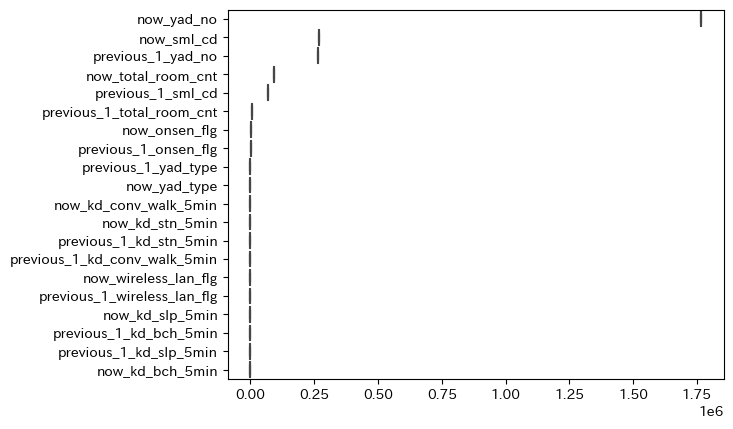

In [94]:
# 特徴量重要度を列にもつDataFrameを作成
feature_importances = [
    model.feature_importance(importance_type="gain") for model in models
]
feature_importances_df = pd.DataFrame(feature_importances, columns=use_col)

# 表示する順番を指定、特徴量重要度の平均が大きい順に並ぶよう計算
order = feature_importances_df.mean().sort_values(ascending=False).index.tolist()

# 表示
# fold毎の特徴量重要度のばらつきを見るために、箱ひげ図を利用
sns.boxplot(data=feature_importances_df, orient="h", order=order)

In [95]:
with open(f"{Config.OUTPUT_DIR}/{NOTEBOOK_NAME}_models.pkl", "wb") as f:
    pickle.dump(models, f)

with open(f"{Config.OUTPUT_DIR}/{NOTEBOOK_NAME}_oof.pkl", "wb") as f:
    pickle.dump(oof, f)

# Testに対する推論

In [96]:
# k 個のモデルの予測を作成. shape = (5, N_test,).
pred = np.array([model.predict(test[use_col]) for model in models])

# k 個のモデルの予測値の平均 shape = (N_test,).
pred = np.mean(pred, axis=0)  # axis=0 なので shape の `k` が潰れる

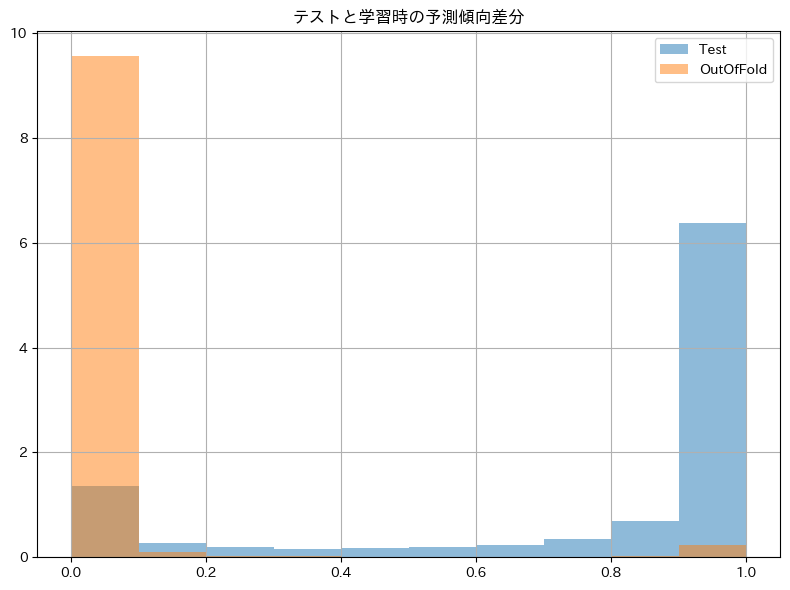

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))

vmax = 0.02
# bins = np.linspace(0, 1, 0.1)
ax.hist(pred, density=True, alpha=0.5, label="Test")
ax.hist(oof, density=True, alpha=0.5, label="OutOfFold")
ax.grid()
ax.legend()
ax.set_title("テストと学習時の予測傾向差分")

fig.tight_layout()

In [37]:
test["pred"] = pred

In [38]:
# session_idごとにpredが高いyadoのlistを取得
pred_yad = (
    test.sort_values(["session_id", "pred"], ascending=False)
    .groupby("session_id")["yad_no"]
    .apply(list)
).to_dict()

In [39]:
test_session["pred_yad_no_list"] = test_session["session_id"].map(pred_yad)

In [40]:
# 上位10件に限定
test_session["pred_yad_no_list_top10"] = test_session["pred_yad_no_list"].apply(
    lambda x: x[:10]
)

In [41]:
# listをpd.Seriesに変換
pred_yad_df = test_session["pred_yad_no_list_top10"].apply(pd.Series)
pred_yad_df = pred_yad_df.rename(columns=lambda x: "predict_" + str(x))

In [42]:
pred_yad_df.head()

,predict_0,predict_1,predict_2,predict_3,predict_4,predict_5,predict_6,predict_7,predict_8,predict_9
0,9830.0,13192.0,6766.0,5466.0,11561.0,4422.0,10233.0,10965.0,1286.0,4584.0
1,6555.0,12862.0,143.0,5267.0,1266.0,7913.0,11923.0,10023.0,8821.0,8108.0
2,1774.0,757.0,410.0,10485.0,7710.0,9708.0,9910.0,4999.0,6037.0,10104.0
3,2795.0,3359.0,10535.0,10527.0,1844.0,1161.0,1542.0,2363.0,6489.0,6991.0
4,9020.0,5106.0,2179.0,12524.0,2554.0,5713.0,2319.0,3187.0,11664.0,13590.0


In [43]:
pred_yad_df.isnull().sum()

predict_0      0
predict_1      0
predict_2      0
predict_3      0
predict_4     47
predict_5    159
predict_6    476
predict_7    619
predict_8    735
predict_9    953
dtype: int64

In [44]:
# Nullの箇所はyad_no=0で保管し、全ての値をintに変換する
pred_yad_df = pred_yad_df.fillna(0).astype(int)

In [45]:
assert pred_yad_df.shape[0] == sample_submission.shape[0]
assert list(pred_yad_df.columns) == list(sample_submission.columns)

In [46]:
pred_yad_df.to_csv(
    f"../sub/{NOTEBOOK_NAME}_auc{oof_score:.4f}_mapk{oof_mapk_score:.4f}.csv",
    index=False,
)

In [47]:
pred_yad_df

,predict_0,predict_1,predict_2,predict_3,predict_4,predict_5,predict_6,predict_7,predict_8,predict_9
0,9830,13192,6766,5466,11561,4422,10233,10965,1286,4584
1,6555,12862,143,5267,1266,7913,11923,10023,8821,8108
2,1774,757,410,10485,7710,9708,9910,4999,6037,10104
3,2795,3359,10535,10527,1844,1161,1542,2363,6489,6991
4,9020,5106,2179,12524,2554,5713,2319,3187,11664,13590
...,...,...,...,...,...,...,...,...,...,...
174695,7888,2278,5744,831,9543,10042,3440,10997,5838,6813
174696,1227,5331,3163,5392,9634,9643,13627,1749,3732,3358
174697,12425,6199,12089,12986,10155,12132,6905,2927,13719,844
174698,5984,4049,4850,6895,12693,13107,3100,11496,2305,2692


In [48]:
sample_submission

,predict_0,predict_1,predict_2,predict_3,predict_4,predict_5,predict_6,predict_7,predict_8,predict_9
0,12217,5055,4744,3410,11442,3711,8190,9998,13023,9297
1,12340,13720,1378,681,2020,11125,10129,4159,8184,7966
2,196,8757,6241,7376,13608,1693,13745,8065,13022,303
3,6448,3482,5687,2335,911,9008,8209,595,8171,10040
4,6327,1606,12898,3785,8212,910,10430,4260,9767,383
...,...,...,...,...,...,...,...,...,...,...
174695,10343,11384,5571,2011,3762,12692,6599,8738,8343,6440
174696,13609,2644,11510,5711,13054,9903,13750,8638,1892,5086
174697,11560,1862,11248,63,12446,9975,13567,7793,5306,9678
174698,7001,4154,11586,3307,13219,12310,5815,5103,510,1351
